In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/ferritin-fo-ml/clean_df1 (1)


In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('../input/ferritin-fo-ml/clean_df1 (1)', parse_dates=['date_bled'],dayfirst=True, dtype={'race':'object'}, index_col=[0])

### Look at data structure

In [4]:
display(df.head())
df.info()

,sample_id,donor_code,ferritin_ratio,race,group_rh,age,clinic_code,date_bled,donations,gender,color,group,rh,ferritin_cat
0,11994897,NIEMALJ0030,1168.0,2.0,O POS,63.0,CAN,2022-03-01,13.0,Female,white,O,POS,very high
1,12028078,SWARTJN0070,2000.0,1.0,B POS,54.0,CCF,2022-05-27,12.0,Male,white,B,POS,very high
2,11994280,FARGHS00010,1572.0,1.0,O POS,58.0,MB4,2022-03-03,19.0,Male,white,O,POS,very high
3,12037507,CONRAL00420,2000.0,2.0,A POS,56.0,CCB,2022-06-20,71.0,Female,white,A,POS,very high
4,50011361,COLLIS00290,1222.0,4.0,O POS,32.0,NC5,2022-03-04,1.0,Female,colored,O,POS,very high


<class 'pandas.core.frame.DataFrame'>
Int64Index: 57665 entries, 0 to 59580
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   sample_id       57665 non-null  int64         
 1   donor_code      57665 non-null  object        
 2   ferritin_ratio  57665 non-null  float64       
 3   race            57665 non-null  object        
 4   group_rh        57665 non-null  object        
 5   age             57665 non-null  float64       
 6   clinic_code     57665 non-null  object        
 7   date_bled       57665 non-null  datetime64[ns]
 8   donations       57665 non-null  float64       
 9   gender          57665 non-null  object        
 10  color           57665 non-null  object        
 11  group           57665 non-null  object        
 12  rh              57665 non-null  object        
 13  ferritin_cat    57665 non-null  object        
dtypes: datetime64[ns](1), float64(3), int64(1), object(9)


In [5]:
# drop columns not needed from import
# Regression models
ferr = df.drop(['sample_id', 'donor_code','race', 'group_rh', 'date_bled', 'ferritin_cat', 'clinic_code'], axis = 1)

# Classification models
ferr_clf = df.drop(['sample_id', 'donor_code','race', 'group_rh', 'date_bled', 'ferritin_ratio', 'clinic_code'], axis = 1)



In [6]:
ferr_clf

,age,donations,gender,color,group,rh,ferritin_cat
0,63.0,13.0,Female,white,O,POS,very high
1,54.0,12.0,Male,white,B,POS,very high
2,58.0,19.0,Male,white,O,POS,very high
3,56.0,71.0,Female,white,A,POS,very high
4,32.0,1.0,Female,colored,O,POS,very high
...,...,...,...,...,...,...,...
59576,47.0,3.0,Female,white,A,POS,normal
59577,51.0,63.0,Female,white,O,POS,normal
59578,36.0,7.0,Female,white,A,POS,normal
59579,59.0,1.0,Male,white,O,POS,high


In [7]:
ferr_clf.iloc[4]

age                  32.0
donations             1.0
gender             Female
color             colored
group                   O
rh                    POS
ferritin_cat    very high
Name: 4, dtype: object

In [8]:
# check numerical
ferr.describe()

,ferritin_ratio,age,donations
count,57665.000000,57665.000000,57665.000000
mean,81.362760,43.137779,31.301171
std,129.689597,15.478606,40.712793
min,1.350000,10.000000,-1.000000
25%,22.500000,30.000000,4.000000
50%,44.700000,44.000000,15.000000
75%,89.900000,55.000000,42.000000
max,4637.000000,87.000000,383.000000


In [9]:
# check object
ferr.describe(include=[object])

,gender,color,group,rh
count,57665,57665,57665,57665
unique,2,4,10,3
top,Female,white,O,POS
freq,30119,35679,27165,50840


array([[<AxesSubplot:title={'center':'ferritin_ratio'}>,
        <AxesSubplot:title={'center':'age'}>],
       [<AxesSubplot:title={'center':'donations'}>, <AxesSubplot:>]],
      dtype=object)

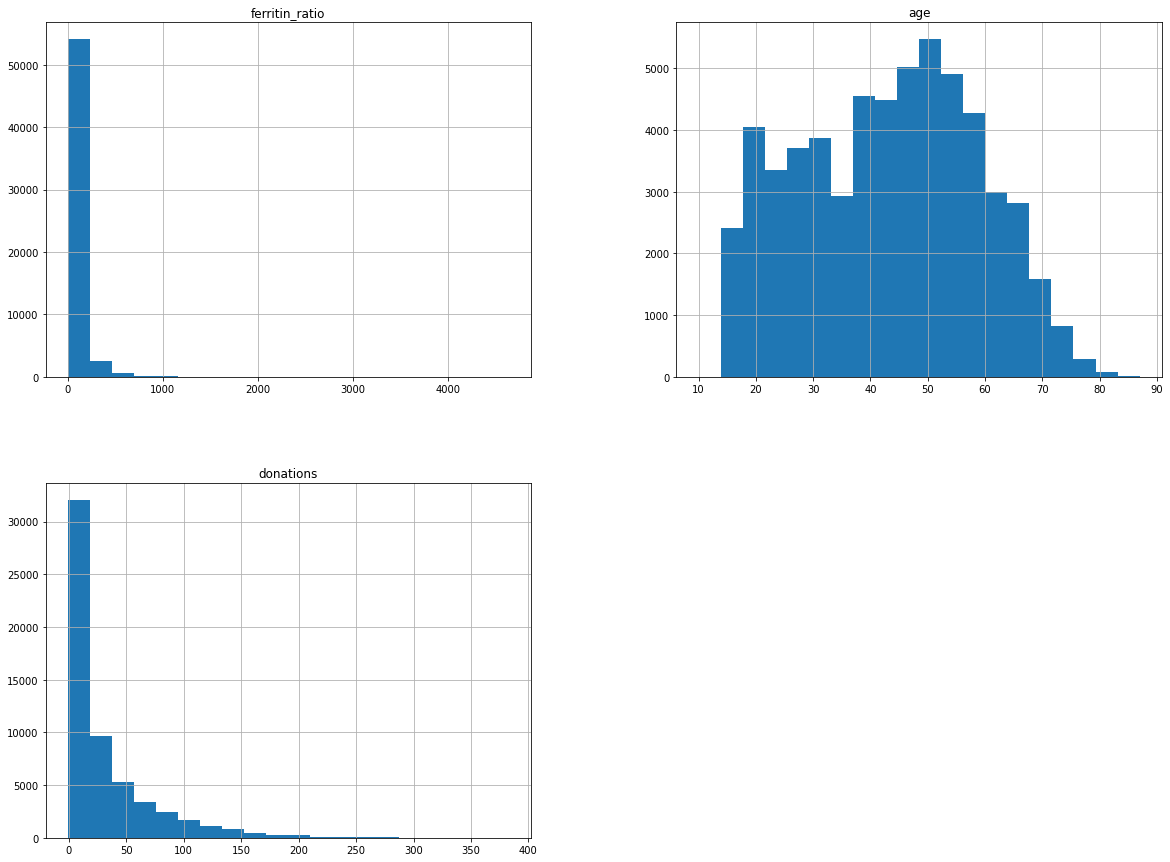

In [10]:
ferr.hist(bins=20,figsize=(20,15))

### Create a test set

In [11]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(ferr, test_size = 20,random_state=1)

train_set_clf, test_set_clf = train_test_split(ferr_clf, test_size = 20,random_state=1)

In [12]:
ferr = train_set.copy()

In [13]:
corr_matrix = ferr.corr()
corr_matrix['ferritin_ratio'].sort_values(ascending=False)

ferritin_ratio    1.000000
age               0.086685
donations        -0.111277
Name: ferritin_ratio, dtype: float64

<AxesSubplot:>

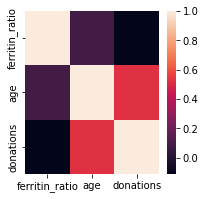

In [14]:
plt.figure(figsize=(3,3))
sns.heatmap(corr_matrix, cmap ='rocket')

### Data Preparation

In [15]:
# revert to clean training set, seperate predictors and target values

# X and y for regression models
ferr = train_set.drop('ferritin_ratio', axis = 1)
ferr_labels = train_set['ferritin_ratio'].copy()

# X and y for classification models
ferr_clf = train_set_clf.drop('ferritin_cat', axis = 1)
ferr_clf_labels = train_set_clf['ferritin_cat'].copy()

In [16]:
# preprocessing transformation pipeline

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

column_trans = make_column_transformer(
    (OneHotEncoder(), ['gender', 'color', 'group', 'rh']),
    (StandardScaler(), ['age', 'donations']))

# column_trans.fit(X)
# column_trans.get_feature_names_out()
# column_trans.transform(X).shape

ferr_prepared = column_trans.fit_transform(ferr)
ferr_prepared_array = column_trans.fit_transform(ferr).toarray() #.toarray() required for PCA

ferr_clf_prepared = column_trans.fit_transform(ferr_clf)
ferr_clf_prepared_array = column_trans.fit_transform(ferr_clf).toarray() #.toarray() required for PCA

### Training and Evaluating Models

In [17]:
# split training set for model evaluation (DO NOT USE TEST_SET YET!)

X_train, X_test, y_train, y_test = train_test_split(ferr_prepared, ferr_labels, test_size=0.20, random_state=1)

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(ferr_clf_prepared, ferr_clf_labels, test_size=0.20, random_state=1)


#### Decision Tree Regressor

In [18]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
import math

model = DecisionTreeRegressor(random_state=1)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f"R2 score: {model.score(X_test, y_test)}\n")
print(f"RMSE: {math.sqrt(mean_squared_error(y_test, y_pred))}\n")
print(f"MAE: {mean_absolute_error(y_test, y_pred)}\n")

scores = cross_val_score(model, ferr_prepared, ferr_labels, cv=10)

print(f"CV scores:\n {scores}\n")
print(f"CV mean: {scores.mean()} R2 score with a standard deviation of { scores.std()}\n") 

R2 score: 0.0634807478745617

RMSE: 124.58420552975362

MAE: 57.634852911449265

CV scores:
 [0.24839118 0.00660573 0.25241188 0.19377678 0.21572445 0.24493031
 0.31255806 0.09285188 0.34558373 0.3381189 ]

CV mean: 0.2250952886558772 R2 score with a standard deviation of 0.1014487698586379



#### Decision Tree Classifier

In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

model = DecisionTreeClassifier()

model.fit(X_train_clf, y_train_clf)

scores = cross_val_score(model, ferr_clf_prepared, ferr_clf_labels, cv=10)

print(f"Accuracy: {model.score(X_test_clf, y_test_clf)}\n")
print(f"ROC_AUC: {roc_auc_score(y_test_clf, model.predict_proba(X_test_clf), multi_class='ovr')}\n")
print(f"CV scores: {scores}")

Accuracy: 0.7708387544453118

ROC_AUC: 0.6555381037819424

CV scores: [0.78282741 0.78421509 0.77970512 0.78074588 0.78560278 0.79042332
 0.78591256 0.78122831 0.78088133 0.78122831]


#### K-Neighbors Classifier

In [20]:
from sklearn.neighbors import KNeighborsClassifier 

model = KNeighborsClassifier()

model.fit(X_train_clf, y_train_clf)

scores = cross_val_score(model, ferr_clf_prepared, ferr_clf_labels, cv=10)

print(f"Accuracy: {model.score(X_test_clf, y_test_clf)}\n")
print(f"ROC_AUC: {roc_auc_score(y_test_clf, model.predict_proba(X_test_clf), multi_class='ovr')}\n")
print(f"CV scores: {scores}")

Accuracy: 0.8080492670656605

ROC_AUC: 0.6566723348298884

CV scores: [0.8123157  0.81162186 0.81543799 0.81300954 0.81023417 0.81922276
 0.81523248 0.81731437 0.81332408 0.81054823]


In [21]:
model.n_samples_fit_

46116

In [22]:
ferr_clf_prepared[4]

<1x21 sparse matrix of type '<class 'numpy.float64'>'
	with 6 stored elements in Compressed Sparse Row format>

In [23]:
model.predict_proba(ferr_clf_prepared[4])

array([[0., 0., 1., 0., 0.]])

In [24]:
from sklearn.linear_model import LogisticRegression 

model = LogisticRegression()

model.fit(X_train_clf, y_train_clf)

scores = cross_val_score(model, ferr_clf_prepared, ferr_clf_labels, cv=10)

print(f"Accuracy: {model.score(X_test_clf, y_test_clf)}\n")
print(f"ROC_AUC: {roc_auc_score(y_test_clf, model.predict_proba(X_test_clf), multi_class='ovr')}\n")
print(f"CV scores: {scores}")

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Accuracy: 0.8301674039378958

ROC_AUC: 0.7407155219545466

CV scores: [0.83590633 0.83573287 0.83590633 0.83590633 0.83573287 0.83587786
 0.83587786 0.83587786 0.83587786 0.83605135]


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [25]:
prob = model.predict_proba(ferr_clf_prepared[4]).flatten()
prob[0]

0.006407290115278793

#### Linear Regression

In [26]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f"R2 score: {model.score(X_test, y_test)}\n")
print(f"RMSE: {math.sqrt(mean_squared_error(y_test, y_pred))}\n")
print(f"MAE: {mean_absolute_error(y_test, y_pred)}\n")

scores = cross_val_score(model, ferr_prepared, ferr_labels, cv=10)

print(f"CV scores:\n {scores}\n")
print(f"CV mean: {scores.mean()} R2 score with a standard deviation of { scores.std()}\n") 

R2 score: 0.10913669268334791

RMSE: 121.50948161458506

MAE: 62.68467896963552

CV scores:
 [0.08426195 0.11813856 0.11118128 0.11898006 0.10630652 0.11826664
 0.10453059 0.11953957 0.11311718 0.10099548]

CV mean: 0.10953178371160335 R2 score with a standard deviation of 0.010498683245891415



#### Ridge Regression

In [27]:
from sklearn.linear_model import Ridge

model = Ridge(alpha=0.5)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f"R2 score: {model.score(X_test, y_test)}\n")
print(f"RMSE: {math.sqrt(mean_squared_error(y_test, y_pred))}\n")
print(f"MAE: {mean_absolute_error(y_test, y_pred)}\n")

scores = cross_val_score(model, ferr_prepared, ferr_labels, cv=10)

print(f"CV scores:\n {scores}\n")
print(f"CV mean: {scores.mean()} R2 score with a standard deviation of { scores.std()}\n") 

R2 score: 0.10911724555073044

RMSE: 121.51080785514752

MAE: 62.68622133992679

CV scores:
 [0.08433118 0.1181385  0.11118091 0.11896046 0.10637052 0.11807149
 0.10452829 0.11968183 0.11313277 0.10068481]

CV mean: 0.10950807814608768 R2 score with a standard deviation of 0.010502259244864061



#### Lasso Regresion

In [28]:
from sklearn.linear_model import Lasso

model = Lasso()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f"R2 score: {model.score(X_test, y_test)}\n")
print(f"RMSE: {math.sqrt(mean_squared_error(y_test, y_pred))}\n")
print(f"MAE: {mean_absolute_error(y_test, y_pred)}\n")

scores = cross_val_score(model, ferr_prepared, ferr_labels, cv=10)

print(f"CV scores:\n {scores}\n")
print(f"CV mean: {scores.mean()} R2 score with a standard deviation of { scores.std()}\n") 

R2 score: 0.10796269224293709

RMSE: 121.58951926856982

MAE: 62.24070666558405

CV scores:
 [0.08358964 0.1190571  0.10978867 0.11769029 0.10674389 0.11775812
 0.10200208 0.11981566 0.1096015  0.09985595]

CV mean: 0.10859028909673218 R2 score with a standard deviation of 0.01073785772691137



#### Random Forest Regressor

In [29]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f"R2 score: {model.score(X_test, y_test)}\n")
print(f"RMSE: {math.sqrt(mean_squared_error(y_test, y_pred))}\n")
print(f"MAE: {mean_absolute_error(y_test, y_pred)}\n")

scores = cross_val_score(model, ferr_prepared, ferr_labels, cv=10)

print(f"CV scores:\n {scores}\n")
print(f"CV mean: {scores.mean()} R2 score with a standard deviation of { scores.std()}\n") 

R2 score: 0.30722616885326415

RMSE: 107.15202165777316

MAE: 53.47968282284653



KeyboardInterrupt: 

#### AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostRegressor

model = AdaBoostRegressor()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f"R2 score: {model.score(X_test, y_test)}\n")
print(f"RMSE: {math.sqrt(mean_squared_error(y_test, y_pred))}\n")
print(f"MAE: {mean_absolute_error(y_test, y_pred)}\n")

scores = cross_val_score(model, ferr_prepared, ferr_labels, cv=10)

print(f"CV scores:\n {scores}\n")
print(f"CV mean: {scores.mean()} R2 score with a standard deviation of { scores.std()}\n") 

#### Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f"R2 score: {model.score(X_test, y_test)}\n")
print(f"RMSE: {math.sqrt(mean_squared_error(y_test, y_pred))}\n")
print(f"MAE: {mean_absolute_error(y_test, y_pred)}\n")

scores = cross_val_score(model, ferr_prepared, ferr_labels, cv=10)

print(f"CV scores:\n {scores}\n")
print(f"CV mean: {scores.mean()} R2 score with a standard deviation of { scores.std()}\n") 

#### Stochastic Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor(subsample=0.7, random_state=42)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f"R2 score: {model.score(X_test, y_test)}\n")
print(f"RMSE: {math.sqrt(mean_squared_error(y_test, y_pred))}\n")
print(f"MAE: {mean_absolute_error(y_test, y_pred)}\n")

scores = cross_val_score(model, ferr_prepared, ferr_labels, cv=10)

print(f"CV scores:\n {scores}\n")
print(f"CV mean: {scores.mean()} R2 score with a standard deviation of { scores.std()}\n") 

#### XGBoost

In [ ]:
# INSERT MODEL

#### Tuning hyperparameters

In [ ]:
dt.get_params()

#### Keras

In [36]:
n_cols = ferr_clf_prepared.shape[1]

In [60]:
target_arr = ferr_clf_labels.values
target = target_arr.reshape(-1,1)

In [64]:
from sklearn.preprocessing import OrdinalEncoder

oe = OrdinalEncoder()

target = oe.fit_transform(target)

In [65]:
from tensorflow.keras.utils import to_categorical

target = to_categorical(target)

In [96]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

from tensorflow.keras.callbacks import EarlyStopping
early_stopping_monitor = EarlyStopping(patience=2)

model = Sequential()

model.add(Dense(100, activation='relu', input_shape=(n_cols,)))

model.add(Dense(100, activation='relu'))

model.add(Dense(100, activation='relu'))

model.add(Dense(5, activation='softmax'))

model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(ferr_clf_prepared, target, epochs=10, callbacks = [early_stopping_monitor])

Epoch 1/10


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_16/dense_35/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_16/dense_35/embedding_lookup_sparse/Reshape:0", shape=(None, 100), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_16/dense_35/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


1802/1802 [==============================] - 7s 4ms/step - loss: 0.5076 - accuracy: 0.8348
Epoch 2/10
1802/1802 [==============================] - 7s 4ms/step - loss: 0.4912 - accuracy: 0.8359
Epoch 3/10
1802/1802 [==============================] - 7s 4ms/step - loss: 0.4878 - accuracy: 0.8359
Epoch 4/10
1802/1802 [==============================] - 7s 4ms/step - loss: 0.4865 - accuracy: 0.8359
Epoch 5/10
1802/1802 [==============================] - 7s 4ms/step - loss: 0.4848 - accuracy: 0.8359
Epoch 6/10
1802/1802 [==============================] - 8s 4ms/step - loss: 0.4839 - accuracy: 0.8359
Epoch 7/10
1802/1802 [==============================] - 8s 4ms/step - loss: 0.4831 - accuracy: 0.8359
Epoch 8/10
1802/1802 [==============================] - 7s 4ms/step - loss: 0.4818 - accuracy: 0.8359
Epoch 9/10
1802/1802 [==============================] - 7s 4ms/step - loss: 0.4812 - accuracy: 0.8359
Epoch 10/10
1802/1802 [==============================] - 7s 4ms/step - loss: 0.4808 - accurac

In [81]:
predictions = model.predict(ferr_clf_prepared[4])

In [90]:
def class_proba(predictions):
    print('very low:  ', predictions[0][0])
    print('low:       ', predictions[0][1])
    print('normal:    ', predictions[0][2])
    print('high:      ', predictions[0][3])
    print('very high: ', predictions[0][4])
    

In [91]:
class_proba(predictions)


very low:   0.00958844
low:        0.10346419
normal:     0.88009
high:       0.0037515708
very high:  0.0031058104


In [ ]:
OLDER CODE

In [ ]:
# model training
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

pca = PCA()
PCA_trans_X = pca.fit_transform(trans_X)
# print(pca.explained_variance_ratio_)

X_train, X_test, y_train, y_test = train_test_split(PCA_trans_X, y, test_size=0.33,random_state=42)

rfr= RandomForestRegressor()

rfr.fit(X_train, y_train)
rfr.score(X_test, y_test)

In [ ]:
column_trans = make_column_transformer(
    (OneHotEncoder(), ['gender', 'color', 'group', 'rh']))

X_OHE = column_trans.fit_transform(X).toarray() #.toarray() required for PCA

pca = PCA()
PCA_X_OHE = pca.fit_transform(X_OHE)
# print(pca.explained_variance_ratio_)

In [ ]:
from sklearn.tree import DecisionTreeRegressor

X_train, X_test, y_train, y_test = train_test_split(PCA_trans_X, y, test_size=0.33,random_state=42)

dt= DecisionTreeRegressor()

dt.fit(X_train, y_train)
dt.score(X_test, y_test)

In [ ]:
# unprocessed df
X_train, X_test, y_train, y_test = train_test_split(PCA_trans_X, y, test_size=0.33,random_state=42)

rfr= RandomForestRegressor()

rfr.fit(X_train, y_train)
rfr.score(X_test, y_test)

In [ ]:
# df['month'] = df['date_bled'].dt.month

# (df.groupby(['donor_code','month'])['ferritin_ratio'].agg('sum').unstack())

# df1.query('age == 60')